## 06. PyTorch Transfer Learning

#### **Transfer learning**

=> involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

- Pretrained model = foundation model

=> e.g. take the patterns a computer vision model has learned from datasets such as `ImageNet`, and use them to power our FoofVision Mini model.

#### Why **Transfer learning**?

- (1) can leverage an existing model (usually a neurl network architecture) proven to work on problems similar to our own
- (2) can leverage a working model which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.1.0.dev20230709
0.16.0.dev20230709


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from go_modular import data_setup, engine

device = "gpu" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_built() else "cpu"
device

'mps'

### 1. Get Data

In [3]:
import os
import zipfile
from pathlib import Path
import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists, skipping re-download.")
else:
    print(f"Did not find {image_path}, downloading it...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists, skipping re-download.


In [4]:
# Setup train and test directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2. Create datasets and dataloaders using script

=> use `data_setup.py` and `create_dataloaders()` function made in notebook05.

=> How to `transform` it?
- (1) manually create transforms -> define what transforms you want you dara to go through
- (2) automatically created transforms -> defined by the model you'd like to use

**Note:** the data that pass through the pre-trained model is `transformed` in the same way that the model was trined on

#### 2.1 **Manually** create a transform for `torchvision.models`

In [5]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize   # make sure images have the same distribution as ImageNet
                # (where our pretrained models have been trained)
])

In [6]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x107da2590>,
 ['pizza', 'steak', 'sushi'])

#### 2.2 **Auto** create transform for `torchvision.models`

=> As of `torchvision v0.13+` there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [7]:
# Get a set of pretrained model weights
# "DEFAULT" = best available weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1673e3eb0>,
 ['pizza', 'steak', 'sushi'])

### 3. Get a pre-trained model

##### various way to get a pre-trained model:
> (1) PyTorch domain libraries
>
> (2) Libraries like `timm` (torch image models)
>
> (3) `HuggingFace Hub` (for plenty of different models)
>
> (4) `Paperswithcode` (for models across different problem spaces/domains)


#### 3.1 Which pretrained model should you use?

##### need to consider:
> (1) speed -> how fast does it need to run?
>
> (2) size -> how big is the model
>
> (3) performance -> how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini)?

https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

For our case (deploying FoodVision Mini on a mobile device), it looks like `EffNetB0` is one of our best options in terms performance vs size.

#### 3.2 Set up a pre-trained model

=> create an instance of a pretrained `EffNetB0` 
https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights

In [10]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# model = torchvision.models.efficientnet_b0(weights=weights).to(device)
# RuntimeError: invalid hash value?

model = torchvision.models.efficientnet_b0()
model.load_state_dict(torch.load("models/efficientnet_b0_rwightman-3dd342df.pth"))
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

#### 3.3 Get a summary of our model with `toechinfo.summary()`

In [12]:
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

#### 3.4 Freeze the base model and Change the output layer to suit our needs

=> freeze the base layers of a pretrained/foundation model and update the output layers to suit owm problem.

In [13]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
    # print(param)
    param.requires_grad = False

In [14]:
# update the classifier head of model to suit our problem
from torch import nn
torch.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [15]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 4. Train the model

In [16]:
# define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
from go_modular import engine
from timeit import default_timer as timer

torch.manual_seed(42)

start_time = timer()
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device="cpu")
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0883 | train_acc: 0.4180 | test_loss: 0.8706 | test_acc: 0.7216
Epoch: 2 | train_loss: 0.9303 | train_acc: 0.6641 | test_loss: 0.7876 | test_acc: 0.7746
Epoch: 3 | train_loss: 0.7696 | train_acc: 0.8438 | test_loss: 0.6673 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.7188 | train_acc: 0.7031 | test_loss: 0.5823 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6964 | train_acc: 0.7266 | test_loss: 0.6199 | test_acc: 0.8258
[INFO] Total training time: 123.256 seconds


### 5. Evaluate model by plotting loss curves

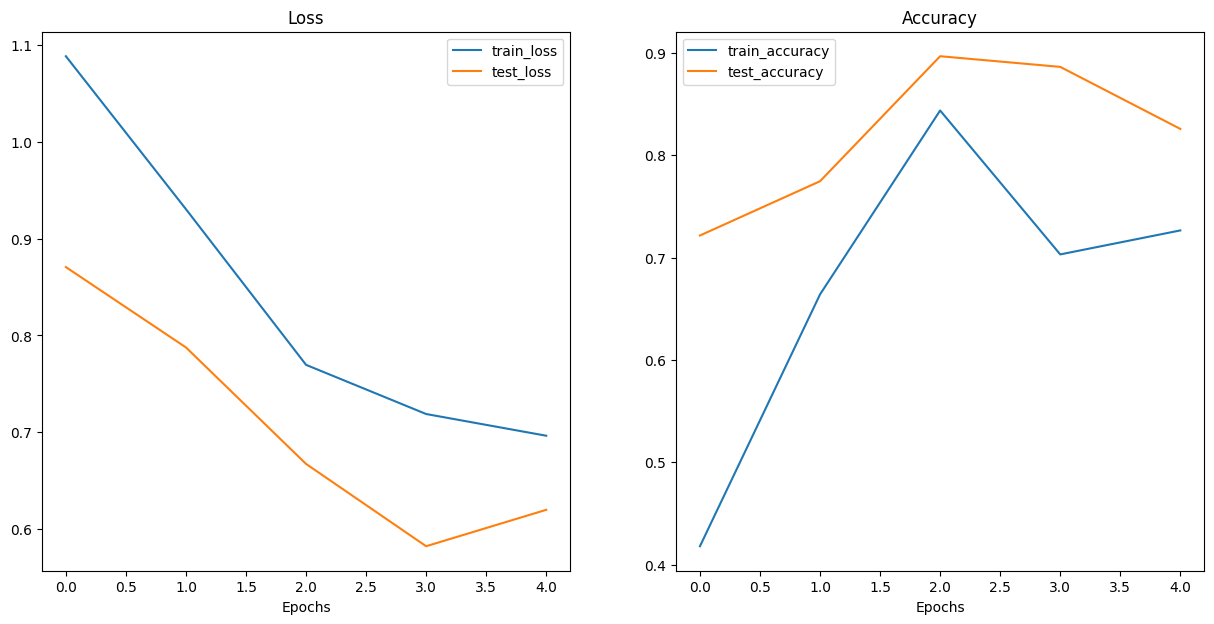

In [18]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

### 6. Make predictions

##### Need to make sure that our test/custom data is:

> (1) same shape -> images need to be the same shape as model was trained on
>
> (2) dame datatype -> custom data should be in the same datatype
>
> (3) same device -> custom data/test data should be on the same device as the model
>
> (4) same transform -> if transformed custom data, ideally you will transform the test data and custom data


#### 6.1 Make predictions on images from the test set

##### => create a function called `pred_and_plot_image()`:
- (1) take a trained model, a list of class names, a filepath to a target image, an image size, a transform and a tarhet device
- (2) open the imahe with `PIL.Image.Open()`
- (3) create a transform if one doesn't exist
- (4) make sure the model is on the target device
- (5) turn the model to `model.eval()` mode
- (6) transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
- (7) make a prediction on the image by passing to the model
- (8) plot the image with `matplotlib`

In [19]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def pred_and_plot_image(model: nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int],
                        transform: torchvision.transforms,
                        device: torch.device):
    img = Image.open(image_path)

    # create a transform is one doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transform.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])
    
    # make sure the model is on the target device
    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)

        target_img_pred = model(transformed_image.to(device))
    
    target_img_pred_prob = torch.softmax(target_img_pred, dim=1)
    target_img_pred_label = torch.argmax(target_img_pred_prob, dim=1)

    # plot the figure
    plt.figure()
    plt.imshow(img) 
    plt.title(f"Pred: {class_names[target_img_pred_label]} | Prob: {target_img_pred_prob.max():.3f}")
    plt.axis(False)

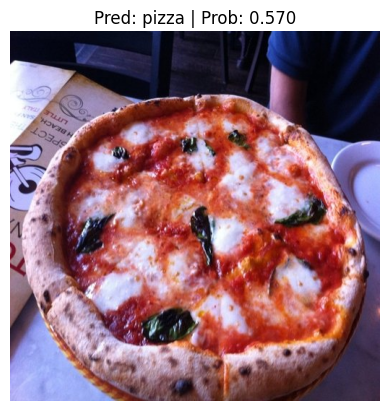

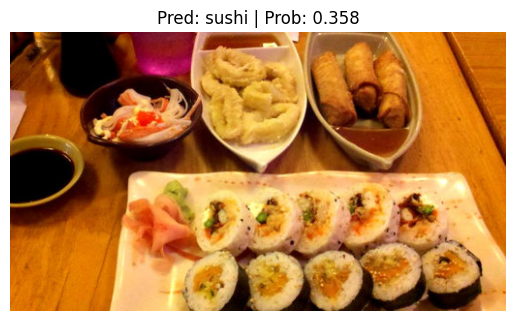

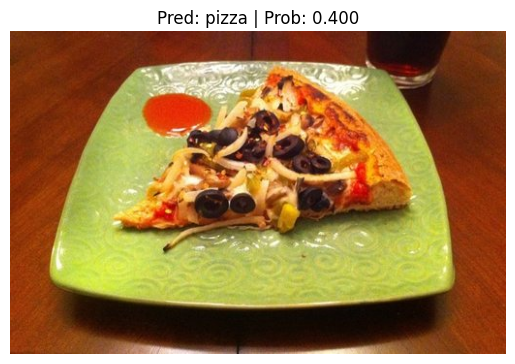

In [20]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224),
                        transform=manual_transform,
                        device="cpu")

#### 6.2 Make predictions on custom images

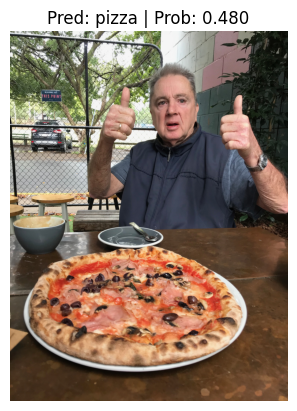

In [21]:
# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    image_size=(224, 224),
                    transform=manual_transform,
                    device="cpu")

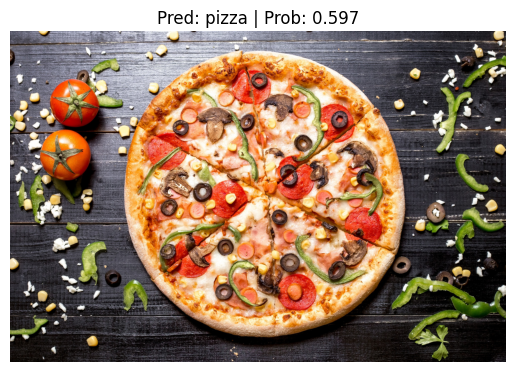

In [22]:
custom_image_path = data_path / "06_custom_pizza.jpg"
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    image_size=(224, 224),
                    transform=manual_transform,
                    device="cpu")

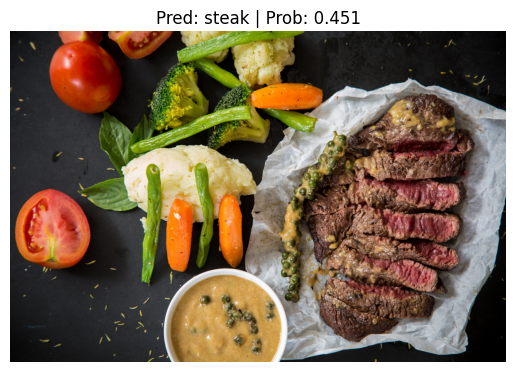

In [23]:
custom_image_path = data_path / "06_custom_steak.jpg"
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    image_size=(224, 224),
                    transform=manual_transform,
                    device="cpu")

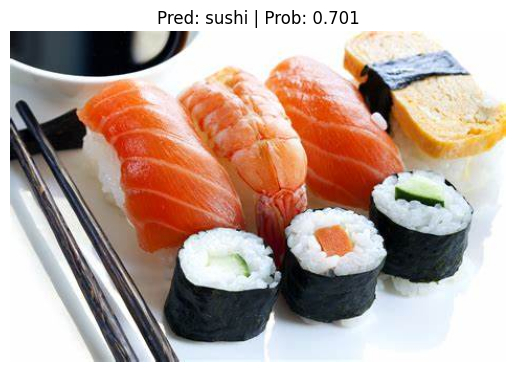

In [25]:
custom_image_path = data_path / "06_custom_sushi.jpeg"
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    image_size=(224, 224),
                    transform=manual_transform,
                    device="cpu")